In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
import seaborn as sns
from sklearn.model_selection import StratifiedKFold

# Dataset preparation

In [126]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mahdimashayekhi/social-media-vs-productivity")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/social-media-vs-productivity


In [127]:
# Load dataset
df = pd.read_csv(path + '/social_media_vs_productivity.csv')

In [128]:
# Remove record with missing values

rows_with_missing = df[df.isnull().any(axis=1)]
print(f"Number of rows with missing values: {len(rows_with_missing)}")

df.dropna(inplace=True)

print("\nRemaining missing values:")
print(df.isnull().sum().sum())

Number of rows with missing values: 12926

Remaining missing values:
0


In [129]:
# Detect and remove outliers using IQR

# List of numeric columns
numeric_columns = [ 'age', 'stress_level', 'number_of_notifications',
        'work_hours_per_day', 'breaks_during_work', 'job_satisfaction_score',
        'coffee_consumption_per_day', 'days_feeling_burnout_per_month',
        'weekly_offline_hours', 'daily_social_media_time', 'screen_time_before_sleep',
        'perceived_productivity_score', 'actual_productivity_score', 'sleep_hours'
]

for col in numeric_columns:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    # Remove outliers
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [130]:
# Remove redundant/uninformative variables

columns_to_remove = ['uses_focus_apps' , 'has_digital_wellbeing_enabled', 'coffee_consumption_per_day', 'perceived_productivity_score']
df.drop(columns=columns_to_remove, axis=1, inplace=True)


In [131]:
# Encode categorical features

categorical_features = df.select_dtypes(include=['object', 'bool']).columns.tolist()
categorical_features.remove('social_platform_preference')  # exclude target
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define preprocessing
numeric_imputer = SimpleImputer(strategy='median')
numeric_scaler = StandardScaler()
categorical_imputer = SimpleImputer(strategy='most_frequent')
categorical_encoder = OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

# Create column transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', Pipeline(steps=[
        ('imputer', numeric_imputer),
        ('scaler', numeric_scaler)
    ]), numerical_features),
    ('cat', Pipeline(steps=[
        ('imputer', categorical_imputer),
        ('encoder', categorical_encoder)
    ]), categorical_features)
])

# Separate features and target
y = df['social_platform_preference']
X = df.drop(columns=['social_platform_preference'])

X_processed = preprocessor.fit_transform(X)

# Get feature names after transformation
encoded_cat_features = preprocessor.named_transformers_['cat']['encoder'].get_feature_names_out(categorical_features)
processed_feature_names = numerical_features + list(encoded_cat_features)

X_processed.shape, pd.DataFrame(X_processed, columns=processed_feature_names).head()


((16503, 19),
         age  daily_social_media_time  number_of_notifications  \
 0  1.052543                 0.616135                 0.149256   
 1  0.329017                 0.113952                -0.117653   
 2  1.052543                 0.724046                 0.015801   
 3 -0.394509                 0.566651                -1.452200   
 4 -0.973329                 0.163535                -0.384563   
 
    work_hours_per_day  actual_productivity_score  stress_level  sleep_hours  \
 0           -0.134138                   1.242078     -0.530539    -0.953130   
 1            1.096206                   0.115401      0.515433    -0.961811   
 2           -1.586291                   0.545265      0.515433     0.716898   
 3           -0.232480                  -1.324783     -0.530539    -0.123394   
 4            2.039813                   1.608564     -0.530539    -1.752007   
 
    screen_time_before_sleep  breaks_during_work  \
 0                 -0.927810            0.944959   
 1

#DIY Classification (logistic regression)

In [135]:
# Encode target labels as integers for DIY implementation
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split the preprocessed dataset for DIY model training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

In [136]:
# Implementing Multinomial Logistic Regression from scratch using softmax
class SoftmaxRegression:
    def __init__(self, learning_rate=0.1, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs

    def _softmax(self, z):
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))  # stability
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)

    def fit(self, X, y):
        self.num_classes = np.max(y) + 1
        self.num_features = X.shape[1]
        self.theta = np.zeros((self.num_features, self.num_classes))

        y_one_hot = np.eye(self.num_classes)[y]

        for _ in range(self.epochs):
            scores = np.dot(X, self.theta)
            probs = self._softmax(scores)
            error = probs - y_one_hot
            grad = np.dot(X.T, error) / X.shape[0]
            self.theta -= self.learning_rate * grad

    def predict(self, X):
        scores = np.dot(X, self.theta)
        probs = self._softmax(scores)
        return np.argmax(probs, axis=1)

In [137]:
# Train the DIY softmax regression model
diy_model = SoftmaxRegression(learning_rate=0.5, epochs=1000)
diy_model.fit(X_train, y_train)
y_pred_diy = diy_model.predict(X_test)

# Train the scikit-learn model for comparison
sk_model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
sk_model.fit(X_train, y_train)
y_pred_sk = sk_model.predict(X_test)

# Evaluate both models
diy_report = classification_report(y_test, y_pred_diy, target_names=label_encoder.classes_, output_dict=True)
sk_report = classification_report(y_test, y_pred_sk, target_names=label_encoder.classes_, output_dict=True)

diy_report_summary = {k: diy_report[k]['f1-score'] for k in label_encoder.classes_}
sk_report_summary = {k: sk_report[k]['f1-score'] for k in label_encoder.classes_}

print("\n\nPlatform | DIY Classification | scikit-learn\n")
for label in label_encoder.classes_:
  print(f"{label}   {round(diy_report[label]['f1-score'], 4)}   {round(sk_report[label]['f1-score'], 4)}")

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(




Platform | DIY Classification | scikit-learn

Facebook   0.1636   0.1605
Instagram   0.1662   0.1527
Telegram   0.2031   0.2021
TikTok   0.2663   0.2581
Twitter   0.1786   0.2023


# Feature selection/engineering

In [138]:
# Check class distribution for `social_platform_preference`
class_distribution = df['social_platform_preference'].value_counts()

class_distribution

,count
social_platform_preference,
TikTok,3373
Twitter,3324
Instagram,3283
Telegram,3269
Facebook,3254


In [139]:
# Create a binary categorical variable

# Define TikTok and Instagram as 'Visual', others as 'Text'
df['platform_type'] = df['social_platform_preference'].apply(
    lambda x: 'Visual' if x in ['TikTok', 'Instagram'] else 'Text'
)

# Check class distribution of new binary variable
binary_distribution = df['platform_type'].value_counts()

binary_distribution

,count
platform_type,
Text,9847
Visual,6656


In [140]:
# Encode the new binary target variable
binary_target_encoded = label_encoder.fit_transform(df['platform_type'])

# Model evaluation

In [141]:
# Feature Set 1: All features
X_features1 = X_processed

# Feature Set 2: Top 10 features
selector = SelectKBest(score_func=f_classif, k=10)
X_features2 = selector.fit_transform(X_processed, binary_target_encoded)

# Split into train/test sets for both feature sets
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X_features1, binary_target_encoded, test_size=0.2, random_state=42, stratify=binary_target_encoded
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X_features2, binary_target_encoded, test_size=0.2, random_state=42, stratify=binary_target_encoded
)

In [142]:
# Train models
rf1 = RandomForestClassifier(random_state=42).fit(X1_train, y1_train)
rf2 = RandomForestClassifier(random_state=42).fit(X2_train, y2_train)
knn1 = KNeighborsClassifier(n_neighbors=5).fit(X1_train, y1_train)
knn2 = KNeighborsClassifier(n_neighbors=5).fit(X2_train, y2_train)

# Predictions
rf1_preds = rf1.predict(X1_test)
rf2_preds = rf2.predict(X2_test)
knn1_preds = knn1.predict(X1_test)
knn2_preds = knn2.predict(X2_test)

# Evaluation
rf1_report = classification_report(y1_test, rf1_preds, target_names=label_encoder.classes_, output_dict=True)
rf2_report = classification_report(y2_test, rf2_preds, target_names=label_encoder.classes_, output_dict=True)
knn1_report = classification_report(y1_test, knn1_preds, target_names=label_encoder.classes_, output_dict=True)
knn2_report = classification_report(y2_test, knn2_preds, target_names=label_encoder.classes_, output_dict=True)

# Extract F1-scores
results = {
    "Random Forest (All features)": {k: rf1_report[k]['f1-score'] for k in label_encoder.classes_},
    "Random Forest (Top 10 features)": {k: rf2_report[k]['f1-score'] for k in label_encoder.classes_},
    "KNN (All features)": {k: knn1_report[k]['f1-score'] for k in label_encoder.classes_},
    "KNN (Top 10 features)": {k: knn2_report[k]['f1-score'] for k in label_encoder.classes_},
}

for name, result in results.items():
  text_val = f"{result['Text']:.4f}"
  visual_val = f"{result['Visual']:.4f}"
  print(f"{name}  Text={text_val}  Visual={visual_val}")

Random Forest (All features)  Text=0.7166  Visual=0.1284
Random Forest (Top 10 features)  Text=0.6966  Visual=0.1901
KNN (All features)  Text=0.6409  Visual=0.3734
KNN (Top 10 features)  Text=0.6338  Visual=0.3541


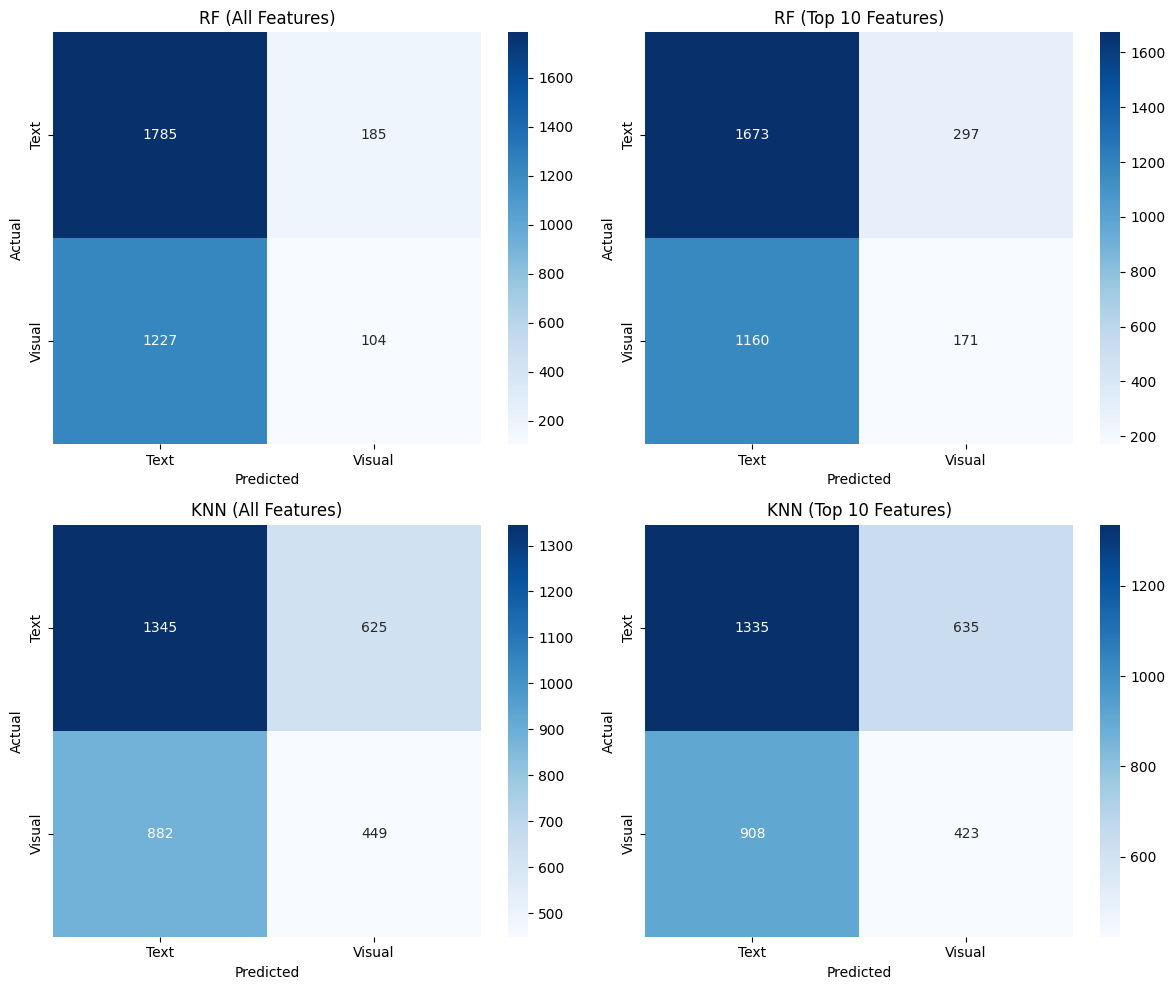

In [143]:
# Create confusion matrix plots
models = {
    "RF (All Features)": (y1_test, rf1_preds),
    "RF (Top 10 Features)": (y2_test, rf2_preds),
    "KNN (All Features)": (y1_test, knn1_preds),
    "KNN (Top 10 Features)": (y2_test, knn2_preds)
}

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, (title, (true, pred)) in enumerate(models.items()):
    cm = confusion_matrix(true, pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, ax=axes[i])
    axes[i].set_title(title)
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Model tuning

In [144]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42), param_grid,
                           scoring='f1_macro', cv=cv, n_jobs=-1, verbose=2)
grid_search.fit(X1_train, y1_train)

best_rf = grid_search.best_estimator_
y_pred_tuned = best_rf.predict(X1_test)

print("\n[Best Parameters]")
print(grid_search.best_params_)
print("Best Cross-Validated F1 Macro Score: {:.4f}".format(grid_search.best_score_))

Fitting 5 folds for each of 8 candidates, totalling 40 fits

[Best Parameters]
{'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Best Cross-Validated F1 Macro Score: 0.5087


In [145]:
print("\n[Tuned Model Report]")
print(classification_report(y1_test, y_pred_tuned, target_names=label_encoder.classes_))


[Tuned Model Report]
              precision    recall  f1-score   support

        Text       0.59      0.62      0.60      1970
      Visual       0.39      0.36      0.37      1331

    accuracy                           0.51      3301
   macro avg       0.49      0.49      0.49      3301
weighted avg       0.51      0.51      0.51      3301



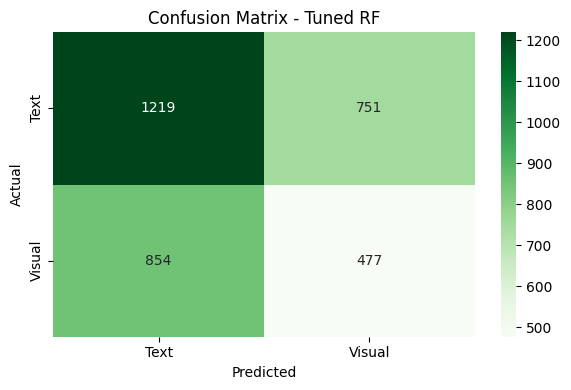

In [146]:
# Confusion Matrix for Tuned Model
cm_tuned = confusion_matrix(y1_test, y_pred_tuned)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Greens', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Tuned RF")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

Random Forest (All features)  Text=0.7166  Visual=0.1284

Tuned Random Forest (All features)  Text=0.60  Visual=0.37